In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [4]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.impute import KNNImputer
from google.colab import drive
drive.mount('/content/gdrive')

BASE_URL = '/content/gdrive/MyDrive/Colab Notebooks/서울 시내버스 공모전/서울 생활이동/data/'

# 시각화 설정
plt.rc('font', family='NanumBarunGothic')
mpl.rcParams["axes.unicode_minus"] = False # 마이너스 기호 깨짐 방지
# plt.rcParams["figure.figsize"] = (20, 10) # 차트 사이즈 설정

# mpl.rc('font', family='Malgun Gothic') # 한글 폰트 적용

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. 자치구/행정동 & 좌표 데이터

### 1) 데이터 불러오기

In [6]:
district_neighbor = {
    '강서구': ['양천구', '영등포구', '마포구'],
    '양천구': ['강서구', '영등포구', '구로구', '마포구'],
    '구로구': ['양천구', '금천구', '영등포구'],
    '영등포구': ['마포구', '양천구', '구로구', '동작구'],
    '금천구': ['구로구', '관악구'],
}

In [7]:
distict_origin = pd.read_excel(BASE_URL + '서울생활이동데이터_행정동코드_20210907.xlsx')

In [8]:
distict_origin.head(2)

,시도,시군구,읍면동,name,full_name
0,11000,11010,1101053,사직동,서울특별시 종로구 사직동
1,11000,11010,1101054,삼청동,서울특별시 종로구 삼청동


In [9]:
geo = gpd.read_file(BASE_URL + '서울_행정동.shp')
geo = geo.iloc[:, [2, 9]]

In [10]:
geo.head(2)

,adm_cd,geometry
0,1101053,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ..."
1,1101054,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ..."


## 1) 전처리
- NaN 없음
- 서울시만 가져오기
- `full_name`에서 시/군/구 컬럼 나누기
- `시도코드`와 `시도명`은 제거

In [11]:
distict_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   시도         1152 non-null   int64 
 1   시군구        1152 non-null   int64 
 2   읍면동        1152 non-null   int64 
 3   name       1152 non-null   object
 4   full_name  1152 non-null   object
dtypes: int64(3), object(2)
memory usage: 45.1+ KB


In [12]:
district = distict_origin.copy()

# 서울시만 가져오기
district = district.loc[district['시도'] == 11000]

# 컬럼 이름 변경
district.columns = ['시도코드', '시군구코드', '읍면동코드', '읍면동', '풀네임']

# '풀네임' -> '자치구' 추출
district['자치구'] = district['풀네임'].str.split().str[1]

# '시도코드', '풀네임' 컬럼 제거
district.drop(columns=['시도코드', '풀네임'], inplace=True)

In [13]:
district.head(5)

,시군구코드,읍면동코드,읍면동,자치구
0,11010,1101053,사직동,종로구
1,11010,1101054,삼청동,종로구
2,11010,1101055,부암동,종로구
3,11010,1101056,평창동,종로구
4,11010,1101057,무악동,종로구


# 2. 서울 생활이동 데이터

## 1) 데이터 불러오기

In [14]:
# csv파일 -> 도착시간 기준
# 출발시간 기준 데이터가 필요함
# 출발시간 = 도착시간 - 이동시간//60
# 근거리 이동 데이터만 필요
# 필요한 파일: 18시 <= 출발시간 <= 21시
move_origins = [
    pd.read_csv(BASE_URL + f'생활이동_행정동_202201/생활이동_행정동_2022.01_{time:02d}시.csv', encoding='cp949') for time in range(18, 23)
]

In [15]:
move_origins[0]

,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합)
0,202201,일,18,1101053,1101053,F,10,EH,10,5.93
1,202201,일,18,1101053,1101053,F,15,EE,30,8.18
2,202201,일,18,1101053,1101053,F,15,HE,10,12.12
3,202201,일,18,1101053,1101053,F,15,EH,10,4.04
4,202201,일,18,1101053,1101053,F,20,WW,10,10.99
...,...,...,...,...,...,...,...,...,...,...
8970429,202201,토,18,39000,1125074,F,35,EW,80,3.01
8970430,202201,토,18,39000,1125074,F,50,EE,80,3.12
8970431,202201,토,18,39000,1125074,F,55,EE,110,3.26
8970432,202201,토,18,39000,1125074,M,55,WE,120,3.26


## 2) 데이터 조작

### a. 시간대별 데이터 concat

In [16]:
move = pd.concat(move_origins, axis=0)
move.shape

(34276130, 10)

### a. 평일 데이터 추출

In [17]:
move = move.loc[~move['요일'].isin(['토', '일'])]
move.shape

(25120234, 10)

### a. 출발시간 컬럼 만들기

In [18]:
move['출발시간'] = move['도착시간'] - move['평균 이동 시간(분)']//60

### a. 퇴근 시간대만 추출: 출발시간 is in (18시 ~ 21시)

In [19]:
move = move.loc[move['출발시간'].between(18, 21)]
move.shape

(21474166, 11)

## 2) 전처리
- NaN 없음
- `이동인구(합)`에서 `*`은 3명이하의 마스킹값 -> 선형보간법

In [20]:
move.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21474166 entries, 1136560 to 4047525
Data columns (total 11 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   대상연월         int64 
 1   요일           object
 2   도착시간         int64 
 3   출발 행정동 코드    int64 
 4   도착 행정동 코드    int64 
 5   성별           object
 6   나이           int64 
 7   이동유형         object
 8   평균 이동 시간(분)  int64 
 9   이동인구(합)      object
 10  출발시간         int64 
dtypes: int64(7), object(4)
memory usage: 1.9+ GB


In [21]:
# '이동인구(합)' == '*' -> 선형보간법

var = '이동인구(합)'
move[var] = move[var].apply(lambda x: '0' if x == '*' else x)
move = move.astype({var:'float'})
move[var] = move[var].apply(lambda x: np.NAN if x == 0 else x)
move[var].interpolate(inplace=True)
# move[var] = KNNImputer(n_neighbors=5).fit_transform(move.loc[:, [var]])

In [22]:
move.head(5)

,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합),출발시간
1136560,202201,월,18,1101053,1101053,F,0,EH,10,27.77,18
1136561,202201,월,18,1101053,1101053,F,15,EH,10,4.04,18
1136562,202201,월,18,1101053,1101053,F,15,EE,10,16.32,18
1136563,202201,월,18,1101053,1101053,F,15,HE,20,16.16,18
1136564,202201,월,18,1101053,1101053,F,15,WH,10,4.04,18


# 3. 행정동 데이터와 합치기

In [23]:
# merge: 출발 행정동 코드
move = pd.merge(move, district, left_on='출발 행정동 코드', right_on='읍면동코드', how='inner')
move.rename(columns={'시군구코드':'출발 자치구 코드', '자치구':'출발 자치구',
                     '읍면동코드':'출발 행정동 코드2', '읍면동':'출발 행정동'}, inplace=True)
move.drop(columns=['출발 행정동 코드2'], inplace=True)

# merge: 도착 행정동 코드
move = pd.merge(move, district, left_on='도착 행정동 코드', right_on='읍면동코드', how='inner')
move.rename(columns={'시군구코드':'도착 자치구 코드', '자치구':'도착 자치구',
                     '읍면동코드':'도착 행정동 코드2', '읍면동':'도착 행정동'}, inplace=True)
move.drop(columns=['도착 행정동 코드2'], inplace=True)

In [24]:
move.head(5)

,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합),출발시간,출발 자치구 코드,출발 행정동,출발 자치구,도착 자치구 코드,도착 행정동,도착 자치구
0,202201,월,18,1101053,1101053,F,0,EH,10,27.77,18,11010,사직동,종로구,11010,사직동,종로구
1,202201,월,18,1101053,1101053,F,15,EH,10,4.04,18,11010,사직동,종로구,11010,사직동,종로구
2,202201,월,18,1101053,1101053,F,15,EE,10,16.32,18,11010,사직동,종로구,11010,사직동,종로구
3,202201,월,18,1101053,1101053,F,15,HE,20,16.16,18,11010,사직동,종로구,11010,사직동,종로구
4,202201,월,18,1101053,1101053,F,15,WH,10,4.04,18,11010,사직동,종로구,11010,사직동,종로구


# 4. 지도 시각화

In [28]:
def show_geo(data, geo, column):
    

    data['adm_cd'] = data['출발 행정동 코드'].astype(str)
    rdata = pd.merge(data, geo, on='adm_cd')
    
    gdf = gpd.GeoDataFrame(rdata, crs='EPSG:4326', geometry='geometry')

    # 지도 시각화
    fig = plt.figure()

    data_top = data.sort_values(by=column, ascending=False)[:10]
    sns.barplot(x='출발 행정동', y=column, data=data_top)

    gdf.plot(column=column,
             legend=True,
             cmap='Blues',
             edgecolor='k',
             legend_kwds={'label': '명'})
    plt.axis('off')
    plt.tight_layout()

    # plt.savefig('예제1.png')
    plt.show()


## 1) 행정동별 이동인구 합 (1)

In [26]:
move_short = move.loc[move['평균 이동 시간(분)'].between(20, 60)]

move_short = move_short.groupby(by=['출발 행정동', '출발 행정동 코드'], as_index=False)['이동인구(합)'].sum()
move_short = move_short.astype({'이동인구(합)':'int'})
move_short.sort_values(by='이동인구(합)', ascending=False, ignore_index=True, inplace=True)
move_short.head(10)

,출발 행정동,출발 행정동 코드,이동인구(합)
0,역삼1동,1123064,1496843
1,여의동,1119054,1392448
2,종로1·2·3·4가동,1101061,1154375
3,명동,1102055,767881
4,서교동,1114066,724731
5,서초3동,1122053,692432
6,가산동,1118051,642213
7,삼성1동,1123058,639475
8,소공동,1102052,562914
9,회현동,1102054,537416


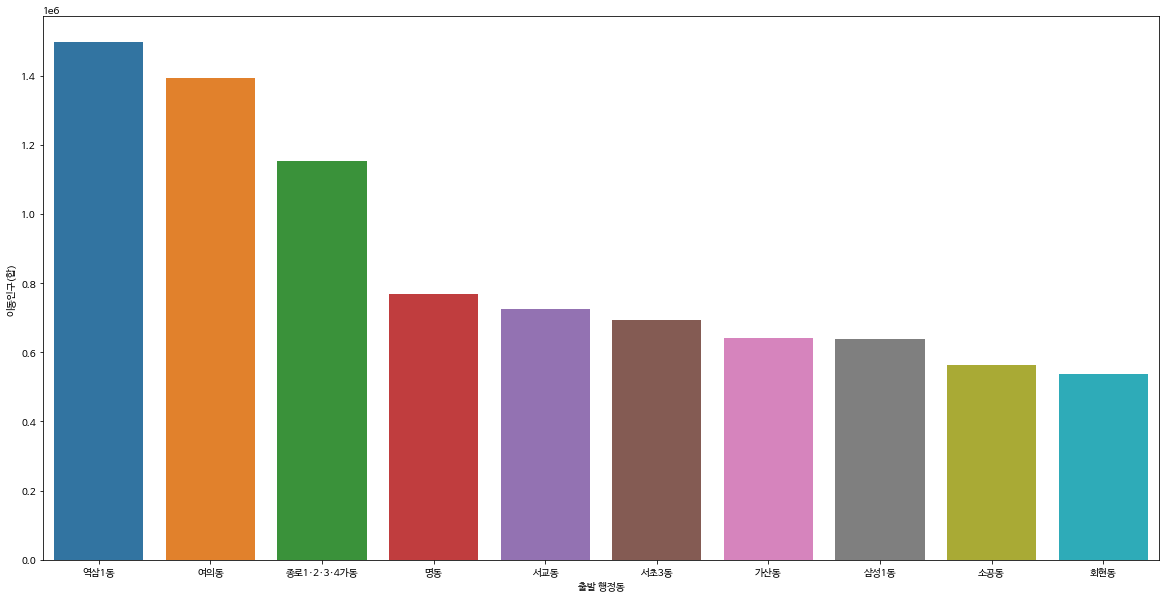

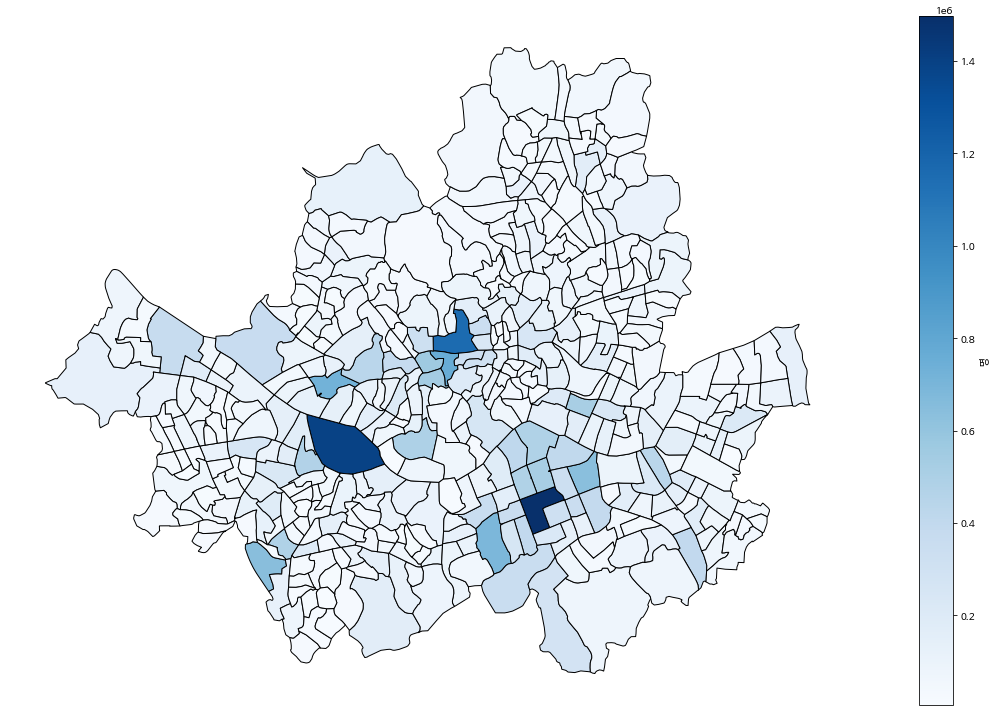

In [30]:
show_geo(move_short, geo, column='이동인구(합)')

## 2) 행정동별 이동인구 합 (2)

In [230]:
# 초근거리(도보 가능성) 제거
# 20 <= 평균이동시간
move_short = move.loc[move['평균 이동 시간(분)'] >= 20]
# move_short = move.loc[move['평균 이동 시간(분)'].between(20, 60)]
# move_short = move

# groupby: 출발행정동 & 도착행정동
move_short = move_short.groupby(by=['출발 행정동', '출발 행정동 코드', '도착 행정동', '도착 행정동 코드'], as_index=False)['이동인구(합)'].sum()
move_short = move_short.astype({'출발 행정동 코드':'str', '도착 행정동 코드':'str', '이동인구(합)':'int'})
move_short.sort_values(by='이동인구(합)', ascending=False, ignore_index=True, inplace=True)

print(move_short.shape)
move_short.head(10)

(170349, 5)


,출발 행정동,출발 행정동 코드,도착 행정동,도착 행정동 코드,이동인구(합)
0,여의동,1119054,영등포동,1119074,33604
1,역삼1동,1123064,역삼1동,1123064,24417
2,강일동,1125051,강일동,1125051,22024
3,가산동,1118051,독산1동,1118052,21453
4,여의동,1119054,당산2동,1119056,20700
5,역삼1동,1123064,청룡동,1121080,20109
6,가산동,1118051,가산동,1118051,19651
7,진관동,1112071,진관동,1112071,19142
8,역삼1동,1123064,신림동,1121069,17181
9,상일동,1125052,상일동,1125052,17140


In [223]:
# 위도/경도 -> x/y 좌표
geo_xy = gpd.GeoDataFrame(geo, crs='EPSG:4326', geometry='geometry')
geo_xy = geo_xy.to_crs(epsg=5186)
geo_xy.head(2)

,adm_cd,geometry
0,1101053,"MULTIPOLYGON (((197958.449 552900.684, 197971...."
1,1101054,"MULTIPOLYGON (((198471.244 555055.390, 198531...."


In [231]:
# merge: move_short & geo_xy
move_short = pd.merge(move_short, geo_xy, left_on='출발 행정동 코드', right_on='adm_cd', how='left')
move_short = pd.merge(move_short, geo_xy, left_on='도착 행정동 코드', right_on='adm_cd', how='left')
move_short.drop(columns=['adm_cd_x', 'adm_cd_y'], inplace=True)
move_short.rename(columns={'geometry_x':'geometry_o', 'geometry_y':'geometry_d'}, inplace=True)
move_short.head(2)

,출발 행정동,출발 행정동 코드,도착 행정동,도착 행정동 코드,이동인구(합),geometry_o,geometry_d
0,여의동,1119054,영등포동,1119074,33604,"MULTIPOLYGON (((192444.575 548964.361, 193412....","MULTIPOLYGON (((192327.236 547217.593, 192343...."
1,역삼1동,1123064,역삼1동,1123064,24417,"MULTIPOLYGON (((204171.535 544946.235, 203781....","MULTIPOLYGON (((204171.535 544946.235, 203781...."


In [232]:
# 출발행정동 - 도착행정동 거리 계산
gdf_o = gpd.GeoDataFrame(move_short.loc[:, ['geometry_o']], crs='EPSG:5186', geometry='geometry_o')
gdf_d = gpd.GeoDataFrame(move_short.loc[:, ['geometry_d']], crs='EPSG:5186', geometry='geometry_d')

move_short['거리'] = gdf_o.distance(gdf_d)
move_short.head()

,출발 행정동,출발 행정동 코드,도착 행정동,도착 행정동 코드,이동인구(합),geometry_o,geometry_d,거리
0,여의동,1119054,영등포동,1119074,33604,"MULTIPOLYGON (((192444.575 548964.361, 193412....","MULTIPOLYGON (((192327.236 547217.593, 192343....",0.0
1,역삼1동,1123064,역삼1동,1123064,24417,"MULTIPOLYGON (((204171.535 544946.235, 203781....","MULTIPOLYGON (((204171.535 544946.235, 203781....",0.0
2,강일동,1125051,강일동,1125051,22024,"MULTIPOLYGON (((215856.126 551904.079, 215864....","MULTIPOLYGON (((215856.126 551904.079, 215864....",0.0
3,가산동,1118051,독산1동,1118052,21453,"MULTIPOLYGON (((189445.230 542953.520, 189587....","MULTIPOLYGON (((190978.084 541337.292, 190943....",0.0
4,여의동,1119054,당산2동,1119056,20700,"MULTIPOLYGON (((192444.575 548964.361, 193412....","MULTIPOLYGON (((191844.010 549132.712, 191848....",0.0


In [226]:
move_short[['거리']].describe().T

,count,mean,std,min,25%,50%,75%,max
거리,169518.0,10255.488245,5912.005052,0.0,5654.190632,9770.536559,14360.974961,30735.600058


In [233]:
# 근거리만 추출
move_short = move_short.loc[move_short['거리'] < 10000]

In [234]:
move_short.head()

,출발 행정동,출발 행정동 코드,도착 행정동,도착 행정동 코드,이동인구(합),geometry_o,geometry_d,거리
0,여의동,1119054,영등포동,1119074,33604,"MULTIPOLYGON (((192444.575 548964.361, 193412....","MULTIPOLYGON (((192327.236 547217.593, 192343....",0.0
1,역삼1동,1123064,역삼1동,1123064,24417,"MULTIPOLYGON (((204171.535 544946.235, 203781....","MULTIPOLYGON (((204171.535 544946.235, 203781....",0.0
2,강일동,1125051,강일동,1125051,22024,"MULTIPOLYGON (((215856.126 551904.079, 215864....","MULTIPOLYGON (((215856.126 551904.079, 215864....",0.0
3,가산동,1118051,독산1동,1118052,21453,"MULTIPOLYGON (((189445.230 542953.520, 189587....","MULTIPOLYGON (((190978.084 541337.292, 190943....",0.0
4,여의동,1119054,당산2동,1119056,20700,"MULTIPOLYGON (((192444.575 548964.361, 193412....","MULTIPOLYGON (((191844.010 549132.712, 191848....",0.0


/usr/local/lib/python3.9/dist-packages/geopandas/plotting.py:955: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  plt.draw()
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: User

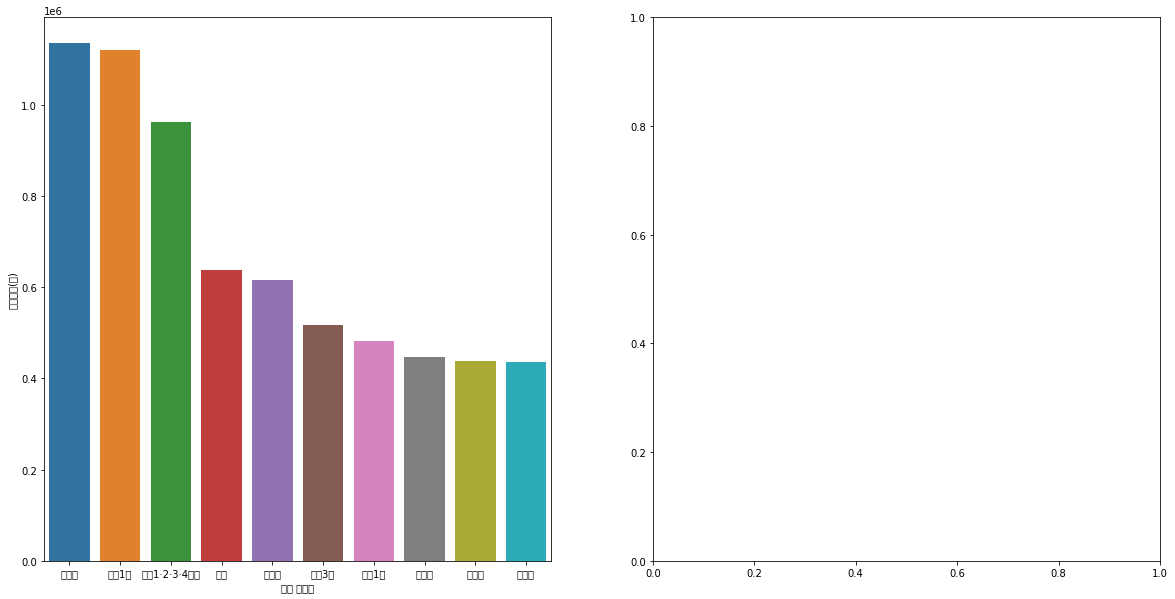

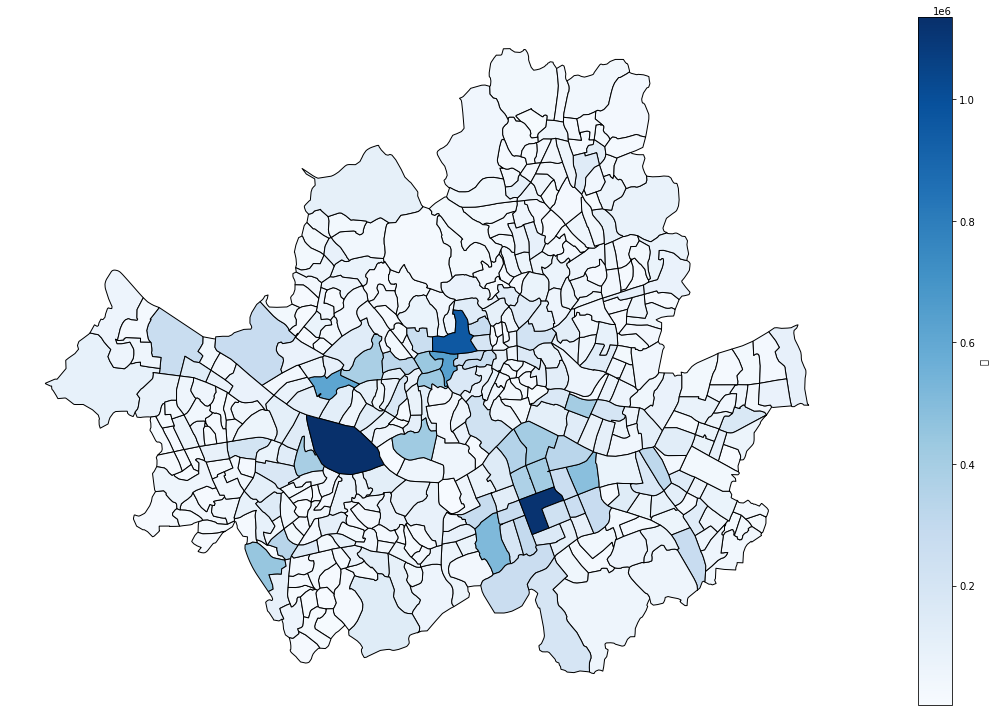

In [238]:
# 출발행정동 -> 이동인구(합): 지도 시각화
move_short_group = move_short.groupby(by=['출발 행정동', '출발 행정동 코드'], as_index=False)['이동인구(합)'].sum()

show_geo(move_short_group, geo, column='이동인구(합)')

# 0. 연습

In [158]:
dis = district.copy()

dis['adm_cd'] = dis['읍면동코드'].astype(str)
dis = pd.merge(dis, geo, on='adm_cd')
gdf = gpd.GeoDataFrame(dis, crs='EPSG:4326', geometry='geometry')
gdf = gdf.to_crs(epsg=5186)
gdf

,시군구코드,읍면동코드,읍면동,자치구,adm_cd,geometry
0,11010,1101053,사직동,종로구,1101053,"MULTIPOLYGON (((197958.449 552900.684, 197971...."
1,11010,1101054,삼청동,종로구,1101054,"MULTIPOLYGON (((198471.244 555055.390, 198531...."
2,11010,1101055,부암동,종로구,1101055,"MULTIPOLYGON (((197867.379 555221.862, 197667...."
3,11010,1101056,평창동,종로구,1101056,"MULTIPOLYGON (((197799.834 559086.753, 197924...."
4,11010,1101057,무악동,종로구,1101057,"MULTIPOLYGON (((196526.290 553472.425, 196714...."
...,...,...,...,...,...,...
418,11250,1125070,둔촌1동,강동구,1125070,"MULTIPOLYGON (((212888.660 546954.717, 212874...."
419,11250,1125071,둔촌2동,강동구,1125071,"MULTIPOLYGON (((213571.787 548288.387, 213574...."
420,11250,1125072,암사1동,강동구,1125072,"MULTIPOLYGON (((212765.648 550592.784, 212652...."
421,11250,1125073,천호2동,강동구,1125073,"MULTIPOLYGON (((211892.626 549742.417, 211590...."


In [153]:
gdf1 = gdf[:10].reset_index(drop=True)
gdf2 = gdf[100:110].reset_index(drop=True)

In [154]:
gdf2

,시군구코드,읍면동코드,읍면동,자치구,adm_cd,geometry
0,11070,1107061,중화1동,중랑구,1107061,"MULTIPOLYGON (((207093.782 555147.816, 207094...."
1,11070,1107062,중화2동,중랑구,1107062,"MULTIPOLYGON (((207093.782 555147.816, 207089...."
2,11070,1107064,묵1동,중랑구,1107064,"MULTIPOLYGON (((207905.230 557786.925, 207989...."
3,11070,1107065,묵2동,중랑구,1107065,"MULTIPOLYGON (((206952.417 556202.103, 206385...."
4,11070,1107068,망우3동,중랑구,1107068,"MULTIPOLYGON (((209926.812 554705.832, 209728...."
5,11070,1107069,신내1동,중랑구,1107069,"MULTIPOLYGON (((210212.284 557750.704, 210326...."
6,11070,1107070,신내2동,중랑구,1107070,"MULTIPOLYGON (((208459.946 555675.296, 208454...."
7,11070,1107071,면목본동,중랑구,1107071,"MULTIPOLYGON (((208268.975 554468.934, 208281...."
8,11070,1107072,면목3·8동,중랑구,1107072,"MULTIPOLYGON (((209728.110 554211.963, 209701...."
9,11070,1107073,망우본동,중랑구,1107073,"MULTIPOLYGON (((210296.760 556588.450, 210342...."


In [157]:
gdf1.geometry.distance(gdf2.geometry)

0     9407.651322
1     7086.786382
2     9118.593627
3     7441.321038
4    11610.719629
5    11697.402775
6     8738.124001
7     7420.453312
8     6555.553415
9     7604.102534
dtype: float64

In [156]:
concat

,시군구코드,읍면동코드,읍면동,자치구,adm_cd,geometry,0
0,NaN,NaN,NaN,NaN,NaN,None,9407.651322
1,NaN,NaN,NaN,NaN,NaN,None,7086.786382
2,NaN,NaN,NaN,NaN,NaN,None,9118.593627
3,NaN,NaN,NaN,NaN,NaN,None,7441.321038
4,NaN,NaN,NaN,NaN,NaN,None,11610.719629
5,NaN,NaN,NaN,NaN,NaN,None,11697.402775
6,NaN,NaN,NaN,NaN,NaN,None,8738.124001
7,NaN,NaN,NaN,NaN,NaN,None,7420.453312
8,NaN,NaN,NaN,NaN,NaN,None,6555.553415
9,NaN,NaN,NaN,NaN,NaN,None,7604.102534


In [128]:
import random

size = len(gdf)
for _ in range(10):
    ran1 = random.randint(0, size-1)
    ran2 = random.randint(0, size-1)

    print(gdf[ran1].distance(gdf[ran2]))

KeyError: ignored

In [121]:


gs1 = dis.loc[dis['읍면동'] == '영등포동']
gdf1 = gpd.GeoDataFrame(gs1, crs='EPSG:4326', geometry='geometry')

gs2 = dis.loc[dis['읍면동'] == '영등포동']
gdf2 = gpd.GeoDataFrame(gs2, crs='EPSG:4326', geometry='geometry')

,시군구코드,읍면동코드,읍면동,자치구,adm_cd,geometry
299,11190,1119074,영등포동,영등포구,1119074,"MULTIPOLYGON (((126.91320 37.52442, 126.91338 ..."


In [119]:
dis['adm_cd'] = dis['읍면동코드'].astype(str)
dis = pd.merge(dis, geo, on='adm_cd')
dis.head(2)

,시군구코드,읍면동코드,읍면동,자치구,adm_cd,geometry_x,geometry_y,geometry
0,11010,1101053,사직동,종로구,1101053,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ...","MULTIPOLYGON (((126.97689 37.57565, 126.97703 ...","MULTIPOLYGON (((126.97689 37.57565, 126.97703 ..."
1,11010,1101054,삼청동,종로구,1101054,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ...","MULTIPOLYGON (((126.98269 37.59507, 126.98337 ...","MULTIPOLYGON (((126.98269 37.59507, 126.98337 ..."


In [116]:
dis.loc[dis['읍면동'] == '영등포동']

,시군구코드,읍면동코드,읍면동,자치구,adm_cd,geometry_x,geometry_y
299,11190,1119074,영등포동,영등포구,1119074,"MULTIPOLYGON (((126.91320 37.52442, 126.91338 ...","MULTIPOLYGON (((126.91320 37.52442, 126.91338 ..."
